In [2]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
# from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
import random
import pickle

In [3]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

In [11]:
avedloss, avedacc, avevloss, avevacc = 0,0,0,0
crit = nn.CrossEntropyLoss()

for i in range(5):
    model = GaussianNB()
    print("Fold %d" % (i + 1))
    trainX = np.empty((0,3,384,683))
    trainY = []
    testX = np.empty((0,3,384,683))
    testY = []
    for j in range(5):
        if i != j:
            trainX = np.append(trainX,data[j],axis=0)
            trainY = trainY + labels[j]
        else:
            testX = data[j]
            testY = labels[j]
    trainX = trainX.reshape((len(trainX),3 * 384 * 683))
    trainY = np.array(trainY)
    testX = testX.reshape((len(testX),3 * 384 * 683))
    testY = np.array(testY)
    model.fit(trainX,trainY)
    train_out = model.predict(trainX)
    test_out = model.predict(testX)
    train_prob_out = model.predict_proba(trainX)
    test_prob_out = model.predict_proba(testX)
    A = torch.from_numpy(np.asarray(train_prob_out,dtype=np.uint8)).type('torch.FloatTensor')
    B = torch.from_numpy(np.asarray(trainY,dtype=np.uint8)).type('torch.LongTensor')
    folddloss = crit(A,B).item()
    A = torch.from_numpy(np.asarray(test_prob_out,dtype=np.uint8)).type('torch.FloatTensor')
    B = torch.from_numpy(np.asarray(testY,dtype=np.uint8)).type('torch.LongTensor')
    foldvloss = crit(A,B).item()
    folddacc = np.mean(train_out == trainY)
    foldvacc = np.mean(test_out == testY)
    print("Fold Train Loss {:.6f} Fold Train Accuracy {:.6f} Fold Test Loss {:.6f} Fold Test Accuracy {:.6f}".format(folddloss,folddacc * 100,foldvloss,foldvacc * 100))
    avedacc += folddacc
    avevacc += foldvacc
    avedloss += folddloss
    avevloss += foldvloss

avedloss /= 5
avedacc /= 5
avevloss /= 5
avevacc /= 5
print("Average Train Loss {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc * 100,avevloss,avevacc * 100))

Fold 1
Fold Train Loss 0.653096 Fold Train Accuracy 0.660167 Fold Test Loss 0.678977 Fold Test Accuracy 0.634286
Fold 2
Fold Train Loss 0.603305 Fold Train Accuracy 0.709091 Fold Test Loss 0.655959 Fold Test Accuracy 0.657303
Fold 3
Fold Train Loss 0.704261 Fold Train Accuracy 0.609001 Fold Test Loss 0.774801 Fold Test Accuracy 0.538462
Fold 4
Fold Train Loss 0.631699 Fold Train Accuracy 0.681564 Fold Test Loss 0.618347 Fold Test Accuracy 0.694915
Fold 5
Fold Train Loss 0.662982 Fold Train Accuracy 0.650281 Fold Test Loss 0.760776 Fold Test Accuracy 0.552486
Average Train Loss 0.651068
Average Train Accuracy: 0.662021
Average Test Loss 0.697772
Average Test Accuracy: 0.615490



In [4]:
avedacc, avevacc = 0,0

model = GaussianNB()
trainX = np.empty((0,3,384,683))
trainY = []
for j in range(5):
    trainX = np.append(trainX,data[j],axis=0)
    trainY = trainY + labels[j]
trainX = trainX.reshape((len(trainX),3 * 384 * 683))
trainY = np.array(trainY)
print(trainX.shape,trainY.shape)

model.fit(trainX,trainY)

train_out = model.predict(trainX)
train_prob_out = model.predict_proba(trainX)
folddacc = np.mean(train_out == np.array(trainY))
print("Validation Train Accuracy {:.6f} ".format(folddacc))

val_out = model.predict(dataVal.reshape(len(dataVal),3 * 384 * 683))
val_prob_out = model.predict_proba(dataVal.reshape(len(dataVal),3 * 384 * 683))
foldvacc = np.mean(val_out == np.array(labelsVal))
print("Validation Test Accuracy {:.6f} ".format(foldvacc))
# print(train_out)
# print(temp_out)

(893, 786816) (893,)
Validation Train Accuracy 0.648376 
Validation Test Accuracy 0.622222 


In [23]:
crit = nn.CrossEntropyLoss()
train_prob_out = torch.from_numpy(np.asarray(train_prob_out,dtype=np.uint8)).type('torch.FloatTensor')
train_labels = torch.from_numpy(np.asarray(trainY,dtype=np.uint8)).type('torch.LongTensor')
loss = crit(train_prob_out, train_labels)
print(loss.item())
val_prob_out = torch.from_numpy(np.asarray(val_prob_out,dtype=np.uint8)).type('torch.FloatTensor')
labels_out = torch.from_numpy(np.asarray(labelsVal,dtype=np.uint8)).type('torch.LongTensor')
loss = crit(val_prob_out, labels_out)
print(loss.item())

0.6648828983306885
0.6910391449928284


In [24]:
with open('naivebayesoutprobs.pt', 'wb') as f:
    pickle.dump(val_prob_out[:,1], f)
with open('naivebayesout.pt', 'wb') as f:
    pickle.dump(val_out, f)


Confusion matrix, without normalization
[[13 12]
 [ 5 15]]
Normalized confusion matrix
[[0.52 0.48]
 [0.25 0.75]]


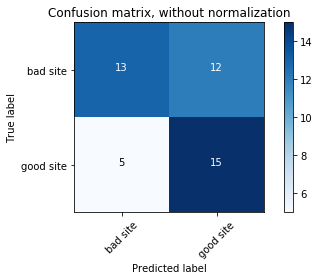

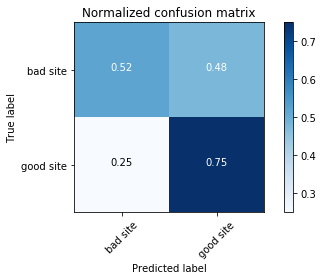

Accuracy: 0.6222


In [25]:
from sklearn.metrics import *
import itertools
import pickle
with open('naivebayesout.pt', 'rb') as f:
    y_pred = pickle.load(f)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labelsVal:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))